After getting all the way to the actual prediction in ARIMA and getting the same error written about all over Google, "ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.", I am trying another approach.  From https://colab.research.google.com/github/goodboychan/chans_jupyter/blob/master/_notebooks/2020-06-15-02-Fitting-the-Future.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [2]:
# Fitting AR and MA models
sample = pd.read_csv('indiv_order_dates_amt_spent.csv', index_col=0)
sample.head()

,TotalSpent,Unnamed: 2
OrderDate,,
2006-07-18,18.99,NaN
2007-05-21,15.63,NaN
2009-06-22,13.18,NaN
2009-07-22,43.45,NaN
2009-11-01,10.49,NaN


In [4]:
# After a couple days struggling through the ValueWarning error, tried the solution suggested here;
# https://stackoverflow.com/questions/58510659/error-valuewarning-a-date-index-has-been-provided-but-it-has-no-associated-fr
sample.index = pd.DatetimeIndex(sample.index).to_period('M')

In [5]:
# AR(2) model
from statsmodels.tsa.arima_model import ARMA

# Instantiate the model
model = ARMA(sample['TotalSpent'], order=(2, 0))

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:             TotalSpent   No. Observations:                  713
Model:                     ARMA(2, 0)   Log Likelihood               -4069.528
Method:                       css-mle   S.D. of innovations             72.869
Date:                Sat, 24 Jul 2021   AIC                           8147.055
Time:                        18:00:26   BIC                           8165.333
Sample:                    07-31-2006   HQIC                          8154.115
                         - 06-30-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               65.8614      2.959     22.260      0.000      60.062      71.660
ar.L1.TotalSpent     0.0824      0.037      2.200      0.028       0.009       0.156
ar.L2.TotalSpent    -0.0046 

In [6]:
# MA(3) model
# Instantiate the model
model = ARMA(sample['TotalSpent'], order=(0, 3))

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:             TotalSpent   No. Observations:                  713
Model:                     ARMA(0, 3)   Log Likelihood               -4069.377
Method:                       css-mle   S.D. of innovations             72.854
Date:                Sat, 24 Jul 2021   AIC                           8148.754
Time:                        18:02:38   BIC                           8171.602
Sample:                    07-31-2006   HQIC                          8157.578
                         - 06-30-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               65.8537      3.010     21.882      0.000      59.955      71.752
ma.L1.TotalSpent     0.0817      0.037      2.181      0.029       0.008       0.155
ma.L2.TotalSpent     0.0020 

In [7]:
# Fitting an ARMAX model, like if I want to model the MoneySpent, which is related to the item count variable.
items = pd.read_csv('indiv_order_dates_total_items.csv', index_col=0, parse_dates=True)
items.head()

,MoneySpent,ItemCount
DateOrdered,,
2006-07-18,18.99,1
2007-05-21,15.63,1
2009-06-22,13.18,2
2009-07-22,43.45,1
2009-11-01,10.49,1


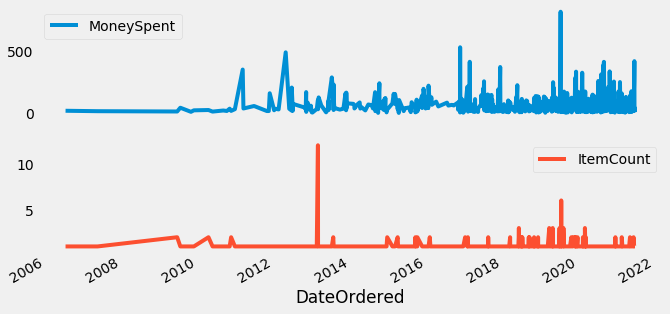

In [9]:
items.plot(subplots=True, grid=False);
# "This is a particularly interesting case of time series modeling as, if the number of items ordered has an effect,
# you could change this to affect the total spent."

In [10]:
# ARMAX (2,1) model to train on the MoneySpent using ItemCount
# Instantiate the model
model = ARMA(items['MoneySpent'], order=(2, 1), exog=items['ItemCount'])

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:             MoneySpent   No. Observations:                  713
Model:                     ARMA(2, 1)   Log Likelihood               -4069.160
Method:                       css-mle   S.D. of innovations             72.831
Date:                Sat, 24 Jul 2021   AIC                           8150.321
Time:                        18:14:38   BIC                           8177.738
Sample:                             0   HQIC                          8160.910
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               64.7572      6.702      9.662      0.000      51.622      77.893
ItemCount            0.9998      5.185      0.193      0.847      -9.163      11.162
ar.L1.MoneySpent     1.0386 

# Forecasting
Generating one-step-ahead predictions

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(items.loc['2009-07-18':'2021-06-27'], order=(3, 1, 3), seasonal_order=(1, 0, 1, 7),
                enforce_invertibility=False,
                enforce_stationarity=False,
                simple_differencing=False, 
                measurement_error=False,
                k_trend=0)
results = model.fit()

# Gets total errors, but keep going...

C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: SARIMAX models require univariate `endog`. Got shape (710, 2).

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             MoneySpent   No. Observations:                  713
Model:                     ARMA(2, 1)   Log Likelihood               -4069.160
Method:                       css-mle   S.D. of innovations             72.831
Date:                Sat, 24 Jul 2021   AIC                           8150.321
Time:                        18:43:16   BIC                           8177.738
Sample:                             0   HQIC                          8160.910
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               64.7572      6.702      9.662      0.000      51.622      77.893
ItemCount            0.9998      5.185      0.193      0.847      -9.163      11.162
ar.L1.MoneySpent     1.0386      0.060     17.171      0.000       0.920       1.157
ar.L2.MoneySpent    -0.0697      0.038     -1.812      0.070      -0.145       0.006
ma.L1.MoneySpent    -0.9580      0.047    -20.311      0.000      -1.050      -0.866
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0347           +0.0000j            1.0347            0.0000
AR.2           13.8652           +0.0000j           13.8652            0.0000
MA.1            1.0439           +0.0000j            1.0439            0.0000
-----------------------------------------------------------------------------
"""

In [17]:
from statsmodels.tsa.arima_model import ARMA

# Generate predictions
one_step_forecast = results.SARIMAXResults.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select upper confidence limit - I don't think I'd have a lower limit.  It would be zero, right?
upper_limits = confidence_intervals.loc[:,'MoneySpent']

# Print best estimate  predictions
print(mean_forecast.values)

AttributeError: 'ARMAResults' object has no attribute 'SARIMAXResults'